In [1]:
#Data from https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
#Data size is relatively small
#Train with more data for better results.
#Might contain bugs that need to be reviewed.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 47.5 MB/s eta 0:00:00


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [5]:
df = pd.read_parquet("de_train.parquet")

In [6]:
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [7]:
smiles=df['SMILES']

In [8]:
df = df.drop(['sm_name', 'sm_lincs_id','control', 'SMILES'], axis=1)

In [9]:
df.head()

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        # Define column names
        self.categorical_column = 'cell_type'
        self.label_encoder = LabelEncoder()
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Separate columns
        self.numerical_columns = [col for col in X.columns if col != self.categorical_column]

        # Fit imputer and scaler on numerical columns
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        self.scaler.fit(X_num_imputed)

        # Fit imputer and label encoder on cell_type
        self.cat_imputer.fit(X[[self.categorical_column]])
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]]).ravel()
        self.label_encoder.fit(cell_type_imputed)

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Impute and scale numerical columns
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Impute and encode categorical column
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]]).ravel()
        cell_type_encoded = self.label_encoder.transform(cell_type_imputed).reshape(-1, 1)

        # Combine and return
        X_processed = np.hstack([cell_type_encoded, X_num_scaled])
        return X_processed

In [11]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [12]:
print(X_transformed.shape)

(614, 18212)


In [13]:
num_num = len(preprocessor.numerical_columns)
print("Numerical feature columns:", preprocessor.numerical_columns)

Numerical feature columns: ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1', 'A4GALT', 'AAAS', 'AACS', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AAR2', 'AARS', 'AARS2', 'AARSD1', 'AASDH', 'AASDHPPT', 'AASS', 'AATBC', 'AATF', 'AATK', 'ABALON', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA11P', 'ABCA2', 'ABCA3', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA9', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCC5', 'ABCD1', 'ABCD2', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABCG2', 'ABCG8', 'ABHD1', 'ABHD10', 'ABHD11', 'ABHD12', 'ABHD13', 'ABHD14A', 'ABHD14A-ACY1', 'ABHD14B', 'ABHD15', 'ABHD15-AS1', 'ABHD16A', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD18', 'ABHD2', 'ABHD3', 'ABHD4', 'ABHD5', 'ABHD6', 'ABHD8', 'ABI1', 'ABI2', 'ABI3', 'ABL1', 'ABL2', 'ABLIM1', 'ABLIM2', 'ABO', 'ABR', 'ABRACL', 'ABRAXAS1', 'ABRAXAS2', 'ABT1', 'ABTB1', 'ABTB2', 'AC000068.1', 'AC000123.2', 'AC000123.3', 'AC000403.1', 'AC001226.2', 'AC002044.1', 'AC002044.2', 'AC0

In [14]:
cat_dim = len(preprocessor.label_encoder.classes_)
print("Categorical feature and label-encoded class count:")
print(f"  cell_type: {cat_dim} unique labels")

print("Total features after transform:", 1 + len(preprocessor.numerical_columns))

Categorical feature and label-encoded class count:
  cell_type: 6 unique labels
Total features after transform: 18212


In [15]:
cat_dims = [len(preprocessor.label_encoder.classes_)]  # only 'cell_type'
num_num = len(preprocessor.numerical_columns)          # numeric gene columns

print("Categorical feature and label-encoded class count:")
print(f"  cell_type: {cat_dims[0]} unique labels")

print("Total numerical features:", num_num)
print("Total features after transform:", 1 + num_num)  # 1 for 'cell_type'

Categorical feature and label-encoded class count:
  cell_type: 6 unique labels
Total numerical features: 18211
Total features after transform: 18212


In [16]:
smiles=np.array(smiles)

In [17]:
print(smiles.shape)

(614,)


In [18]:
print(X_transformed.shape)

(614, 18212)


In [66]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input

# === Encoder ===
def build_encoder(input_dim, latent_dim, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.GaussianNoise(noise_stddev)(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inputs, z, name="encoder")

# === Decoder ===
def build_decoder(latent_dim, vocab_size, max_length, embed_dim=64, l2_reg=1e-4):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = layers.Dense(max_length * embed_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(latent_inputs)
    x = layers.Reshape((max_length, embed_dim))(x)
    x = layers.GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.TimeDistributed(layers.Dense(vocab_size + 1, activation='softmax'))(x)
    return Model(latent_inputs, outputs, name="decoder")

# === MMD Loss ===
def mmd_loss(z, prior_z, sigma=1.0):
    def gaussian_kernel(x, y, sigma):
        x_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
        y_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
        dist = x_norm - 2 * tf.matmul(x, tf.transpose(y)) + tf.transpose(y_norm)
        return tf.exp(-dist / (2.0 * sigma ** 2))

    k_xx = gaussian_kernel(z, z, sigma)
    k_yy = gaussian_kernel(prior_z, prior_z, sigma)
    k_xy = gaussian_kernel(z, prior_z, sigma)

    return tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)

In [20]:
#Wasserstein Autoencoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.models import Model

def build_encoder(input_dim, latent_dim, timesteps=None, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    if timesteps is not None:
        inputs = Input(shape=(timesteps, input_dim))  # Sequence input
        x = layers.Masking(mask_value=0.0)(inputs)
        x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    else:
        inputs = Input(shape=(input_dim,))  # Flat input
        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)

    x = layers.GaussianNoise(noise_stddev)(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inputs, z, name="encoder")

def build_decoder(latent_dim, vocab_size, max_length, embed_dim=64, l2_reg=1e-4):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

    # Project latent vector to an embedding sequence
    x = layers.Dense(max_length * embed_dim, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(latent_inputs)
    x = layers.Reshape((max_length, embed_dim))(x)

    # RNN to generate token sequence
    x = layers.GRU(128, return_sequences=True,
                   kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.TimeDistributed(layers.Dense(vocab_size + 1, activation='softmax'))(x)  # +1 for padding

    return Model(latent_inputs, outputs, name="decoder")

def build_critic(latent_dim, l2_reg=1e-4):
    inputs = Input(shape=(latent_dim,), name='critic_input')
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out = layers.Dense(1)(x)  # Wasserstein scalar score
    return Model(inputs, out, name="critic")

In [78]:
@tf.function
def train_step(batch_x, batch_smiles, lambda_mmd=10.0):
    with tf.GradientTape() as tape:
        z = encoder(batch_x)
        prior_z = tf.random.normal(shape=tf.shape(z))
        decoded = decoder(z)
        recon_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(batch_smiles, decoded))
        mmd = mmd_loss(z, prior_z)
        total_loss = recon_loss + lambda_mmd * mmd

    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return recon_loss, mmd, total_loss

# Set params
latent_dim = 32
batch_size = 64
epochs = 500
lambda_mmd = 10.0
input_dim = X_transformed.shape[1]
vocab_size = len(char_to_idx)
max_length = smiles_encoded.shape[1]

# Build models
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, vocab_size, max_length)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_transformed.astype(np.float32), smiles_encoded.astype(np.int32)))
dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Training loop
for epoch in range(epochs):
    recon_losses, mmd_losses, total_losses = [], [], []
    for batch_x, batch_smiles in dataset:
        recon, mmd, total = train_step(batch_x, batch_smiles, lambda_mmd)
        recon_losses.append(recon.numpy())
        mmd_losses.append(mmd.numpy())
        total_losses.append(total.numpy())
    print(f"Epoch {epoch+1}/{epochs} | Recon: {np.mean(recon_losses):.4f} | MMD: {np.mean(mmd_losses):.4f} | Total: {np.mean(total_losses):.4f}")

Epoch 1/500 | Recon: 3.4629 | MMD: 0.0502 | Total: 3.9652
Epoch 2/500 | Recon: 3.2896 | MMD: 0.0336 | Total: 3.6260
Epoch 3/500 | Recon: 2.9439 | MMD: 0.0334 | Total: 3.2784
Epoch 4/500 | Recon: 2.3896 | MMD: 0.0334 | Total: 2.7237
Epoch 5/500 | Recon: 1.9416 | MMD: 0.0334 | Total: 2.2758
Epoch 6/500 | Recon: 1.7354 | MMD: 0.0334 | Total: 2.0694
Epoch 7/500 | Recon: 1.6397 | MMD: 0.0334 | Total: 1.9737
Epoch 8/500 | Recon: 1.5670 | MMD: 0.0334 | Total: 1.9009
Epoch 9/500 | Recon: 1.5251 | MMD: 0.0334 | Total: 1.8591
Epoch 10/500 | Recon: 1.4873 | MMD: 0.0334 | Total: 1.8213
Epoch 11/500 | Recon: 1.4652 | MMD: 0.0334 | Total: 1.7991
Epoch 12/500 | Recon: 1.4545 | MMD: 0.0334 | Total: 1.7885
Epoch 13/500 | Recon: 1.4389 | MMD: 0.0334 | Total: 1.7729
Epoch 14/500 | Recon: 1.4262 | MMD: 0.0334 | Total: 1.7601
Epoch 15/500 | Recon: 1.4232 | MMD: 0.0334 | Total: 1.7572
Epoch 16/500 | Recon: 1.4179 | MMD: 0.0334 | Total: 1.7518
Epoch 17/500 | Recon: 1.4110 | MMD: 0.0334 | Total: 1.7450
Epoch 

In [68]:
import numpy as np

def generate_smiles(input_vector, encoder, decoder, idx_to_char, preprocessor=None,
                    num_samples=1, max_length=None, temperature=1.0):
    """
    Generate SMILES strings from a single input vector, with temperature sampling.

    Args:
        input_vector (np.ndarray or pd.Series or dict): raw or preprocessed input vector
        encoder (tf.keras.Model): trained encoder model
        decoder (tf.keras.Model): trained decoder model
        idx_to_char (dict): mapping from token index to character
        preprocessor (CustomPreprocessor, optional): preprocess input if provided
        num_samples (int): number of SMILES strings to generate
        max_length (int, optional): max length of output sequences
        temperature (float): softmax temperature (lower = conservative, higher = diverse)

    Returns:
        list of str: list of generated SMILES strings
    """
    # Preprocess if needed
    if preprocessor is not None:
        import pandas as pd
        if isinstance(input_vector, dict):
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, np.ndarray) and input_vector.ndim == 1:
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, pd.Series):
            input_vector = input_vector.to_frame().T
        input_vector = preprocessor.transform(input_vector)

    # Prepare input for encoder
    input_vector = np.array(input_vector, dtype=np.float32)
    if input_vector.ndim == 1:
        input_vector = np.expand_dims(input_vector, axis=0)

    # Encode to latent space
    z = encoder.predict(input_vector, verbose=0)

    # Decode sequence probabilities
    decoded_seq = decoder.predict(z, verbose=0)  # (1, max_length, vocab_size+1)
    if max_length is None:
        max_length = decoded_seq.shape[1]

    vocab_size_plus = decoded_seq.shape[2]

    samples = []
    for _ in range(num_samples):
        smiles_chars = []
        for t in range(max_length):
            logits = decoded_seq[0, t]  # shape: (vocab_size+1,)
            # Apply temperature
            logits = np.log(logits + 1e-9) / temperature
            probs = np.exp(logits) / np.sum(np.exp(logits))

            token_idx = np.random.choice(vocab_size_plus, p=probs)
            if token_idx == 0:  # Padding or stop
                break
            smiles_chars.append(idx_to_char.get(token_idx, ''))
        smiles = ''.join(smiles_chars)
        samples.append(smiles)

    return samples if num_samples > 1 else samples[0]

In [97]:
# Choose a temperature (e.g., 0.7 for conservative, 1.0 for standard, 1.5+ for diverse)
temperature = 1.5

# Set number of samples
num_samples = 70000

# Optionally add preprocessor if you're using raw input (like a dict or DataFrame row)
# Example with preprocessor:
# input_data = your_raw_input_dict_or_dataframe_row
# generated_smiles_list = generate_smiles(input_data, encoder, decoder, idx_to_char,
#                                         preprocessor=preprocessor,
#                                         num_samples=num_samples,
#                                         max_length=max_smiles_length,
#                                         temperature=temperature)

# If using already preprocessed input:
generated_smiles_list = generate_smiles(
    input_vector=X_transformed[1],
    encoder=encoder,
    decoder=decoder,
    idx_to_char=idx_to_char,
    num_samples=num_samples,
    max_length=max_smiles_length,
    temperature=temperature
)

In [98]:
from rdkit import Chem

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None and len(smi) >= 5:
            valid_smiles.append(smi)
    return valid_smiles

In [99]:
valid_smiles = filter_valid_smiles(set(generated_smiles_list))

Streaming output truncated to the last 5000 lines.
[17:32:08] SMILES Parse Error: check for mistakes around position 32:
[17:32:08] (cnccccc1)(c1ccccc1)l1ccnc1
[17:32:08] ~~~~~~~~~~~~~~~~~~~~^
[17:32:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccccc1C(cnccccc1)(c1ccccc1)l1ccnc1' for input: 'Clc1ccccc1C(cnccccc1)(c1ccccc1)l1ccnc1'
[17:32:08] SMILES Parse Error: unclosed ring for input: 'Clc1ccccc1C(c1ccccc1)2c1ccc(c1)n1ccnn1'
[17:32:08] SMILES Parse Error: extra open parentheses while parsing: CNc1ccccc(C(c1cccccFC(c21cccc1)n1ccnc1
[17:32:08] SMILES Parse Error: check for mistakes around position 10:
[17:32:08] CNc1ccccc(C(c1cccccFC(c21cccc1)n1ccnc1
[17:32:08] ~~~~~~~~~^
[17:32:08] SMILES Parse Error: extra open parentheses while parsing: CNc1ccccc(C(c1cccccFC(c21cccc1)n1ccnc1
[17:32:08] SMILES Parse Error: check for mistakes around position 12:
[17:32:08] CNc1ccccc(C(c1cccccFC(c21cccc1)n1ccnc1
[17:32:08] ~~~~~~~~~~~^
[17:32:08] SMILES Parse Error: Failed parsing SMILES 'CNc1cccc

In [100]:
print(len(valid_smiles))

124


In [101]:
valid_smiles

['C/c1ccccc1C(c1ccccc1)(c1ccccc1)n1cccc1',
 'NOc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1',
 'CCc1ccccc1',
 'OSc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1',
 'Clc1ccccc1C(c1ccccc1)(c1ccccc1)c1-cnc1',
 'Clc1cccccsC(n1ccccc1)(ccccccc1)n1ccnc1',
 'Clc1ccccc1C(c1cccc31)(c1cccc31)n1cccc1',
 'Clc1cccON1C(c1ccccc1)(c1ccccc1)n1ccnc1',
 'COc1c2ccc1C(c1ccccc1)(c1ccccc1)n1c2nc1',
 'Clc1ccccc1C(c1ccccc1C(c1ccccc1))1ccnc1',
 'COc1ccccc1C(cnccccc1c(c1ccccc1))cccnI1',
 'Clc1cccccNC(c1ccccc1s(c3)cccc3)nCccnc1',
 'Clc1cccccOC(c1ccccc1)(c1ccccc1)ncccnc1',
 'CNc1/ccccNC(c1ccccc1)(ccccccc1)n1ccnc1',
 'Clc1ccccc1C(c1ccccc1)(c1ccccc1)C1ccnc1',
 'OCc1ccccc1C(c1ccccc1)(c1ccccc1)n1cccc1',
 'Clc1ccccc1C(c1ccccc1c(c1)cccc1)n1ccnc1',
 'C=c1scccc1C(c1ccccc1)(c1ccc1c1)ncccNc1',
 'Clc1cccccnC(c1ccccc1)(cOccccc1)n1ccnc1',
 'CCc1c2ccc1C(c1ccccc1)(c1c2ccc1)c1ocnc1',
 'COc1SccccOC(cnccccc1)(c1ccccc1)n1ccnc1',
 'Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ncnc1',
 'CNc1ccccccC(cNccccc1c(c1)cccc1)n1ccnc1O',
 'Clc1ccccc1C(ccccccc1)(cnccccc1)n1ccn

In [102]:
#Optional plotting for diversity

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_smiles_diversity(smiles_list):
#   # Convert SMILES to Morgan fingerprints
     fps = []
     for smi in smiles_list:
         mol = Chem.MolFromSmiles(smi)
         if mol is not None:
             fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
             fps.append(fp)

     # Convert fingerprints to numpy array
     arr = []
     for fp in fps:
         arr.append(np.array(list(fp.ToBitString()), dtype=int))
     arr = np.array(arr)

     # Use t-SNE for 2D visualization
     tsne = TSNE(n_components=2, random_state=42)
     reduced = tsne.fit_transform(arr)

     # Plot the diversity
     plt.figure(figsize=(8, 6))
     plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
     plt.title('Diversity Plot of Valid SMILES')
     plt.xlabel('t-SNE Dimension 1')
     plt.ylabel('t-SNE Dimension 2')
     plt.show()

[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerat

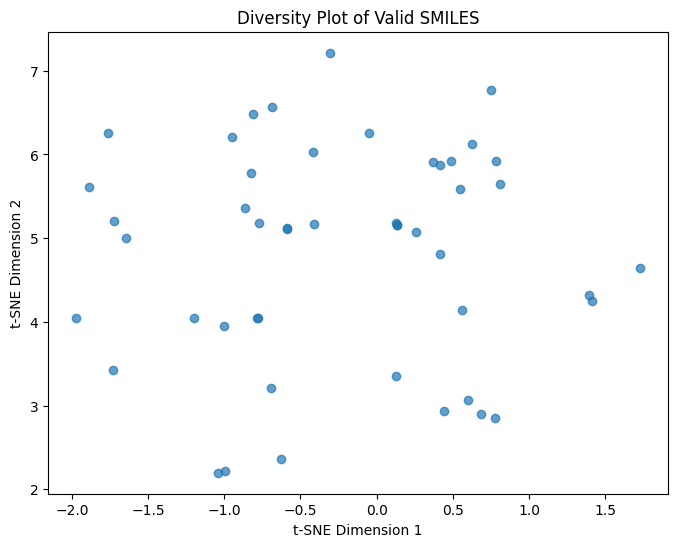

In [103]:
plot_smiles_diversity(valid_smiles2)